Title: k-means on MNIST and incremental k-means
Author: Thomas Breuel
Institution: UniKL

In [5]:

from pylab import *
from scipy.spatial import distance
from scipy.ndimage import interpolation
import tables
import random as pyrandom

# Reading MNIST

In [6]:
with tables.openFile("mnist.h5","r") as mnist:
    images = array(mnist.root.deskewed,'f')
    labels = array(mnist.root.labels,'i')
    test_images = array(mnist.root.test_deskewed,'f')
    test_labels = array(mnist.root.test_labels,'i')

In [7]:
def showgrid(images,rows=None,cols=10,size=1):
    if rows is None: rows = (len(images)+cols-1)//cols
    figsize(cols*size,rows*size)
    for i in range(len(images)):
        subplot(rows,cols,i+1)
        imshow(images[i])

The k-Means Algorithm
=====================

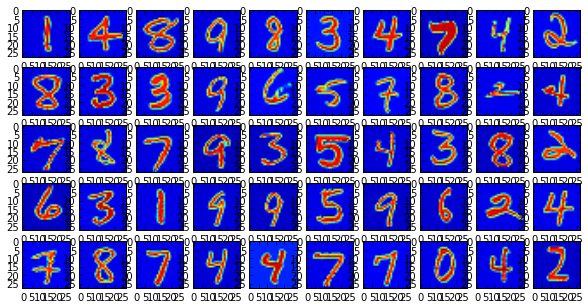

In [8]:
protos = array(pyrandom.sample(images,50),'f')
showgrid(protos)

In [9]:
from scipy.spatial.distance import cdist
def make2d(a): return a.reshape(len(a),prod(a.shape[1:]))
closest = argmin(cdist(make2d(protos),make2d(images)),axis=0)
for i in range(len(protos)):
    protos[i,:] = average(images[closest==i,:],axis=0)

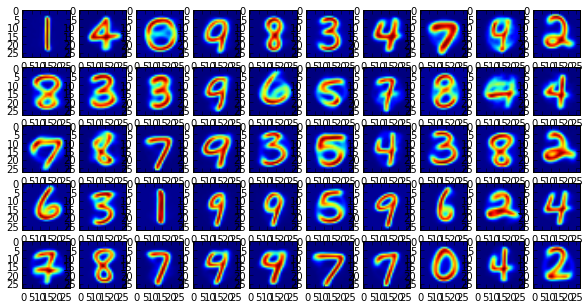

In [10]:
showgrid(protos)

In [11]:
def kmeans(images,k=50,protos=None,maxrounds=50,verbose=1):
    last_closest = -ones(len(images))
    if protos is None: protos = array(pyrandom.sample(images,k))
    for round in range(maxrounds):
        dists = cdist(make2d(protos),make2d(images))
        distortion = sum(amin(dists,axis=0))/len(images)
        closest = argmin(dists,axis=0)
        delta = sum(closest!=last_closest)
        last_closest = closest
        if verbose: print round,delta,distortion
        if delta==0: break
        for i in range(len(protos)):
            protos[i,:] = average(images[closest==i,:],axis=0)
    return protos

In [12]:
protos = kmeans(images,protos=protos)

0 60000 4.92791306455
1 7305 4.82339143232
2 4623 4.79399193763
3 3300 4.77928160063
4 2627 4.77048787612
5 2235 4.76362848654
6 2097 4.75668127095
7 1968 4.74945883203
8 1812 4.74279501946
9 1677 4.73792616002
10 1571 4.73414826073
11 1426 4.73091656985
12 1308 4.72803567943
13 1181 4.72545593468
14 1147 4.72316953402
15 1045 4.72116153654
16 981 4.71948076779
17 846 4.71796113487
18 786 4.71677505258
19 730 4.71561093964
20 679 4.71449332524
21 579 4.71364371291
22 560 4.71299215707
23 505 4.71244373033
24 413 4.71209851374
25 371 4.71189952536
26 329 4.7117341214
27 310 4.71159143583
28 286 4.71143996534
29 257 4.71131827684
30 248 4.71122405847
31 232 4.71109889008
32 221 4.71098626593
33 210 4.71089035961
34 216 4.71079365751
35 205 4.71069452515
36 196 4.71059435099
37 181 4.71050412731
38 165 4.71042813068
39 146 4.71035513104
40 126 4.71029115546
41 107 4.71026061801
42 102 4.71025368955
43 105 4.71023436355
44 97 4.71021570777
45 96 4.71018738721
46 72 4.71014924186
47 74 4.71

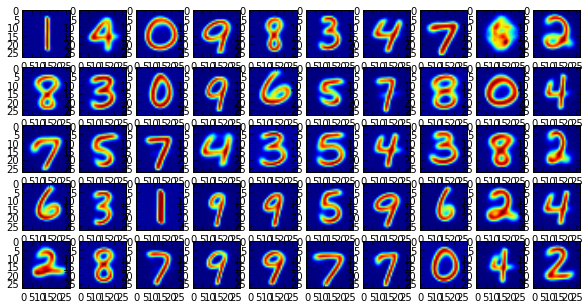

In [13]:
showgrid(protos)

k-Means as a Classifier
=======================

In [14]:
dists = cdist(make2d(protos),make2d(images))
closest = argmin(dists,axis=0)

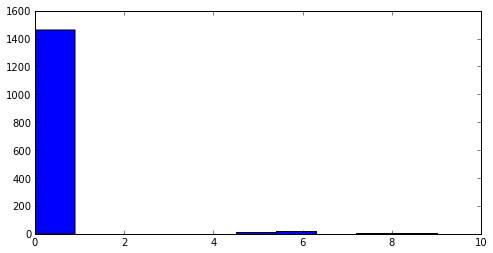

In [15]:
figsize(8,4)
_=hist(labels[closest==2])

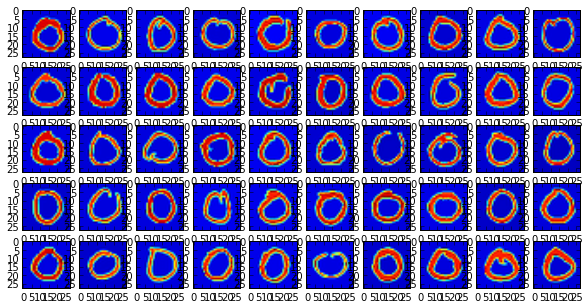

In [16]:
showgrid(images[closest==2][:50])

In [17]:
def chist(classes,n=10):
    result = zeros(n)
    for i in range(n):
        result[i] = sum(classes==i)
    return array(result,'i')

dists = cdist(make2d(protos),make2d(images))
closest = argmin(dists,axis=0)
proto_labels = [argmax(chist(labels[closest==i])) for i in range(50)]
sorted(set(proto_labels))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [18]:
def nneval(training,ltraining,testing,ltesting,metric='euclidean',p=2):
    ds = distance.cdist(make2d(testing),make2d(training),metric=metric,p=p)
    closest = argmin(ds,axis=1)
    predictions = [ltraining[i] for i in closest]
    errors = sum(array(predictions)!=array(ltesting))
    return errors*1.0/len(testing)

In [19]:
nneval(protos,proto_labels,test_images,test_labels)

0.094399999999999998

In [20]:
for k in [20,20,20,50,100,200,500]:
    protos = kmeans(images,k=k,verbose=0,maxrounds=10)
    dists = cdist(make2d(protos),make2d(images))
    closest = argmin(dists,axis=0)
    proto_labels = [argmax(chist(labels[closest==i])) for i in range(len(protos))]
    print "RESULT",k,nneval(protos,proto_labels,test_images,test_labels)

RESULT 20 0.1848
RESULT 20 0.2246
RESULT 20 0.1765
RESULT 50 0.1094
RESULT 100 0.0698
RESULT 200 0.0553
RESULT 500 0.0452


k-Means with Stochastic Gradient Descent
========================================

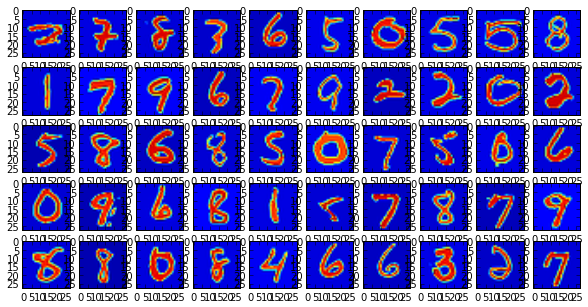

In [21]:
protos = array(pyrandom.sample(images,50))
counts = zeros(50)
showgrid(protos)

In [22]:
for iter in range(200000):  
    alpha = 1/(100+iter)**.3
    if iter%20000==0: print iter,alpha
    i = iter%len(images)
    j = argmin(cdist([images[i].ravel()],make2d(protos))[0])
    counts[j] += 1
    # protos[j] = (1-alpha)*protos[j]+alpha*images[i]
    protos[j] -= alpha*(protos[j]-images[i])

0 0.251188643151
20000 0.0511730359013
40000 0.0415964902615
60000 0.0368415300499
80000 0.03379949762
100000 0.0316132959304
120000 0.0299320938173
140000 0.0285804168933
160000 0.0274588661711
180000 0.0265061032987


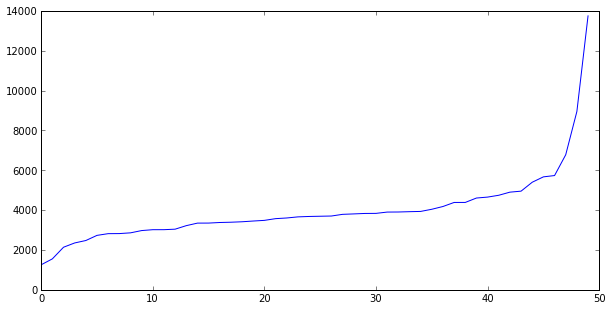

In [23]:
plot(sorted(counts))

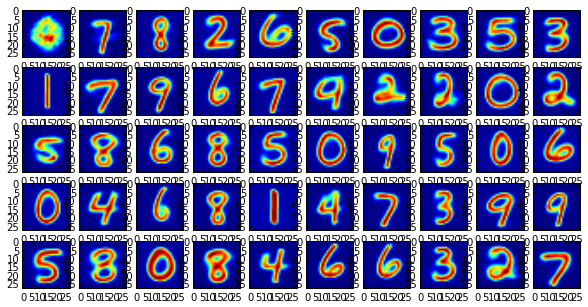

In [24]:
showgrid(protos)